# Итоговый проект
Распознавание сердечно-сосудистых заболеваний

Импортируем библиотеки и модули для работы

In [1]:
import pandas as pd
from missingno import matrix
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

Получение данных из датасета

In [2]:
df = pd.read_csv('cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Информация о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Описательные статистики датасета

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


Преобразуем данные датасета

In [6]:
# Удалим id пациента и целевую переменную из датасета

target_data = df['cardio']
df = df.drop(columns=['id', 'cardio'])

Визуализация пропусков датасета

<Axes: >

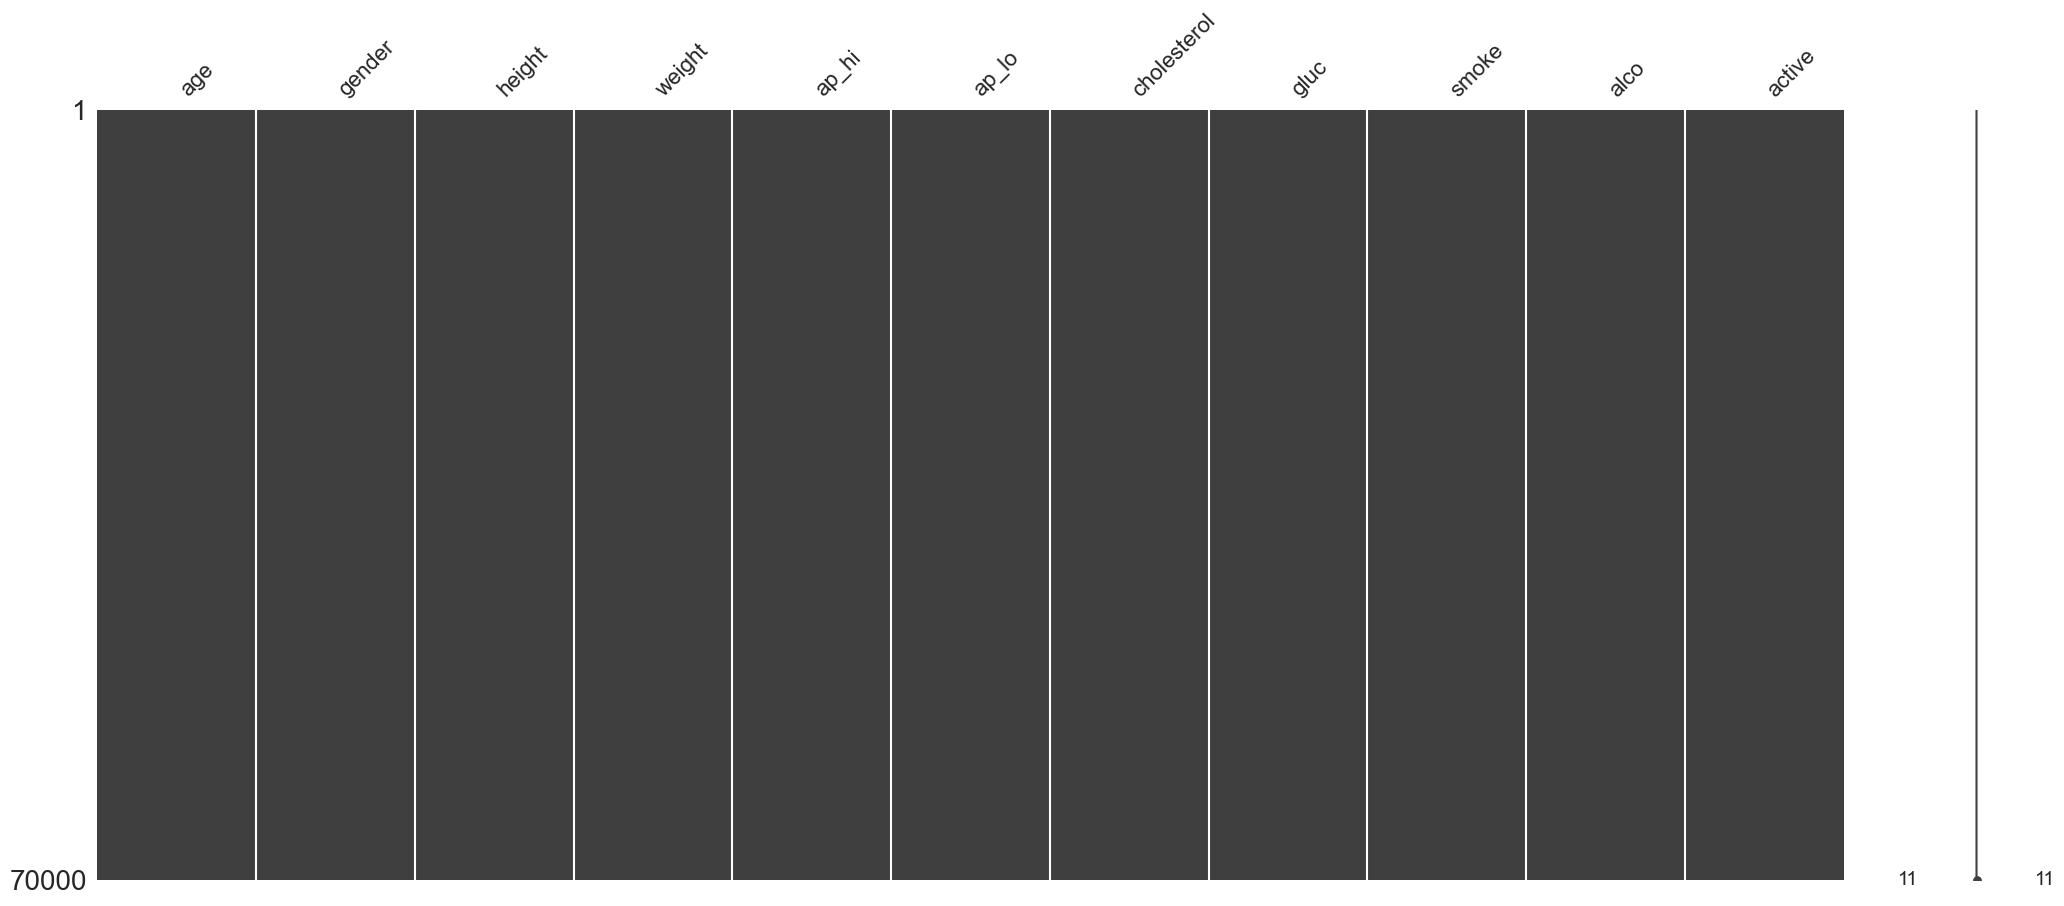

In [7]:
matrix(df)

Проверка датасета на наличие пропусков

In [8]:
binary_columns = df.columns[df.isin([0, 1]).all()]
df_check = df.drop(columns=binary_columns)

def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (column < lower_bound) | (column > upper_bound)
    return outliers

print("Выбросы")
for column in df_check.columns:
    if pd.api.types.is_numeric_dtype(df_check[column]):
        outliers = detect_outliers(df_check[column])
        print(f"Количество выбросов в столбце '{column}': {outliers.sum()} ({round((outliers.sum() / df_check[column].size), 2)})")

Выбросы
Количество выбросов в столбце 'age': 4 (0.0)
Количество выбросов в столбце 'gender': 0 (0.0)
Количество выбросов в столбце 'height': 519 (0.01)
Количество выбросов в столбце 'weight': 1819 (0.03)
Количество выбросов в столбце 'ap_hi': 1435 (0.02)
Количество выбросов в столбце 'ap_lo': 4632 (0.07)
Количество выбросов в столбце 'cholesterol': 0 (0.0)
Количество выбросов в столбце 'gluc': 10521 (0.15)


Избавимся от выбросов с помощью метода межквартильного интервала

In [9]:
Q1 = df_check.quantile(0.25)
Q3 = df_check.quantile(0.75)

df = df.drop(columns=df_check)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

column_to_check = df_check[(df_check >= lower_bound) & (df_check <= upper_bound)]
df = pd.concat([column_to_check, df], axis=1)

Избавимся от пропусков в датасете

In [10]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

imputer = KNNImputer()
df_filled = imputer.fit_transform(df)
df_filled_original = scaler.inverse_transform(df_filled)
df = pd.DataFrame(df_filled_original, columns=df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  float64
 2   height       70000 non-null  float64
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  float64
 5   ap_lo        70000 non-null  float64
 6   cholesterol  70000 non-null  float64
 7   gluc         70000 non-null  float64
 8   smoke        70000 non-null  float64
 9   alco         70000 non-null  float64
 10  active       70000 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


Выполним нормализацию и стандартизацию данных

In [11]:
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

normalized_data = minmax_scaler.fit_transform(df)
df = pd.DataFrame(normalized_data, columns=df.columns)

standard_data = standard_scaler.fit_transform(df)
df = pd.DataFrame(standard_data, columns=df.columns)

df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,-0.436398,1.364055,0.470154,-0.905920,-1.062436,-0.251989,-0.539322,0.0,-0.310879,-0.238384,0.494167
1,0.307602,-0.733108,-1.105485,0.953922,0.889390,1.029498,2.400793,0.0,-0.310879,-0.238384,0.494167
2,-0.248270,-0.733108,0.076244,-0.744195,0.238781,-1.533476,2.400793,0.0,-0.310879,-0.238384,-2.023607
3,-0.748595,1.364055,0.601457,0.711334,1.539999,2.310984,-0.539322,0.0,-0.310879,-0.238384,0.494167
4,-0.809007,-0.733108,-1.105485,-1.391096,-1.713045,-1.097770,-0.539322,0.0,-0.310879,-0.238384,-2.023607


Проверка баланса данных

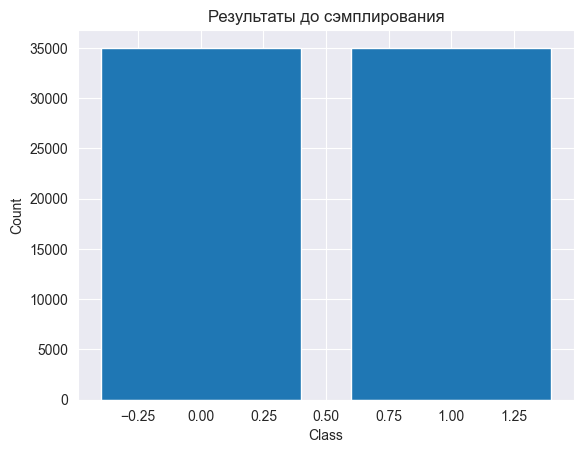

In [12]:
counter = Counter(target_data)
for k,v in counter.items():
    per = v / len(target_data) * 100
plt.bar(counter.keys(), counter.values())
plt.title("Результаты до сэмплирования")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


Подготовка данных для обучения

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df, target_data, test_size=0.3)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Bagging Classifier

In [14]:
bagging_clf = BaggingClassifier()

# Вычисление accuracy с помощью кросс-валидации
bagging_accuracy = cross_val_score(bagging_clf, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()

param_grid = {
    'n_estimators': [10, 50, 100], 
    'max_samples': [0.5, 1.0],     
    'max_features': [0.5, 1.0]        
}

grid_search = GridSearchCV(estimator=bagging_clf, param_grid=param_grid, cv=stratified_kfold)
grid_search.fit(X_train, y_train)
print("Лучшие гиперпараметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Bagging Accuracy Score: {accuracy}")
print(f"Bagging Cross Validation Accuracy: {bagging_accuracy}")

Лучшие гиперпараметры: {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}
Bagging Accuracy Score: 0.7229523809523809
Bagging Cross Validation Accuracy: 0.6907551020408162


AdaBoost Classifier

In [15]:
adaboost_clf = AdaBoostClassifier()

# Вычисление accuracy с помощью кросс-валидации
adaboost_accuracy = cross_val_score(adaboost_clf, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()

param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0] 
}

grid_search = GridSearchCV(estimator=adaboost_clf, param_grid=param_grid, cv=stratified_kfold)
grid_search.fit(X_train, y_train)
print("Лучшие гиперпараметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy Score: {accuracy}")
print(f"AdaBoost Cross Validation Accuracy: {bagging_accuracy}")

C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\sagop\venv\lib\site-pac

Лучшие гиперпараметры: {'learning_rate': 1.0, 'n_estimators': 200}
AdaBoost Accuracy Score: 0.7267142857142858
AdaBoost Cross Validation Accuracy: 0.6907551020408162


Градиентный бустинг

In [16]:
gradient_clf = GradientBoostingClassifier()

# Вычисление accuracy с помощью кросс-валидации
gradient_accuracy = cross_val_score(gradient_clf, X_train, y_train, cv=stratified_kfold, scoring='accuracy').mean()

param_grid = {
    'n_estimators': [50, 100, 200],  
    'learning_rate': [0.1, 0.5, 1.0] 
}

grid_search = GridSearchCV(estimator=gradient_clf, param_grid=param_grid, cv=stratified_kfold)
grid_search.fit(X_train, y_train)
print("Лучшие гиперпараметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy Score: {accuracy}")
print(f"AdaBoost Cross Validation Accuracy: {accuracy}")

Лучшие гиперпараметры: {'learning_rate': 0.1, 'n_estimators': 200}
AdaBoost Accuracy Score: 0.731904761904762
AdaBoost Cross Validation Accuracy: 0.731904761904762
